<a href="https://colab.research.google.com/github/Le4o/topicos-avancados-ic/blob/main/GAN_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho GAN + VAE/AE
#### Exercício da matéria de Tópicos Avançados em Inteligência Computacional

Grupo:
- João Victor de Sledz Bulhões
- Leonardo de Andrade Santana
- Lis da Silva Azevedo

### Definição do Exercício

O trabalho consiste em criar uma GAN para criar dados artificiais para o dataset Medical MNIST (https://www.kaggle.com/andrewmvd/medical-mnist) de shape reduzido (32x32) e posteriormente utilizar uma rede VAE ou AE para aumentar a dimensionalidade da imagem para 64x64.
Serão consideradas as 2 redes como parte do trabalho e a redução do shape inicial deve ser feito via código.

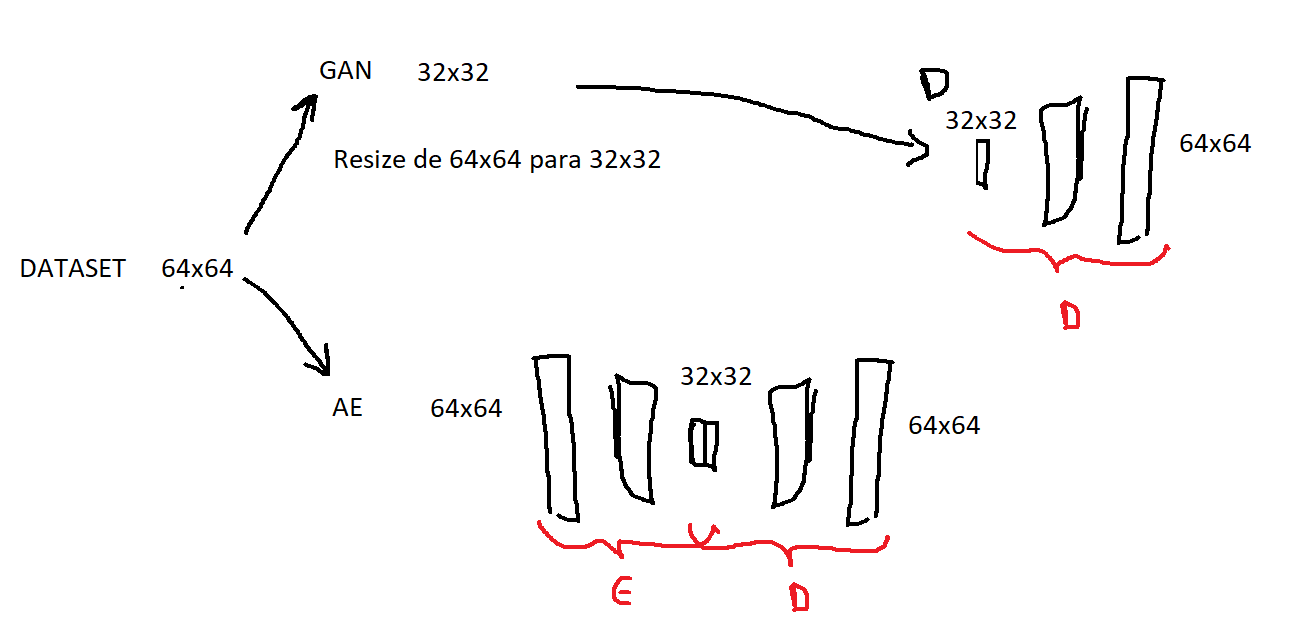

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [3]:
def count_of_images(dir_path):
    path, dirs, files = next(os.walk(dir_path))
    return len(files)

In [4]:
abdomenCT_count = count_of_images("Datasets/medical_mnist/AbdomenCT/")
breastMRI_count = count_of_images("Datasets/medical_mnist/BreastMRI/")
chestCT_count = count_of_images("Datasets/medical_mnist/ChestCT/")

In [5]:
classes = ["AbdomenCT", "BreastMRI", "ChestCT"]
number_of_classes = [abdomenCT_count, breastMRI_count, chestCT_count]

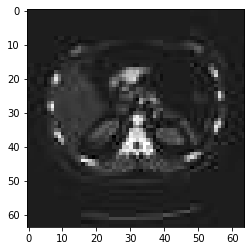

In [6]:
abdomen_img = np.asarray(Image.open("Datasets/medical_mnist/AbdomenCT/000000.jpeg"))
plt.imshow(abdomen_img, cmap="gray")

In [7]:
# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3), (0.3))
])

In [23]:
dataset = datasets.ImageFolder("Datasets/medical_mnist/", transform=transform)

train_set, val_set = torch.utils.data.random_split(dataset, [23954, 5000])

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=4)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


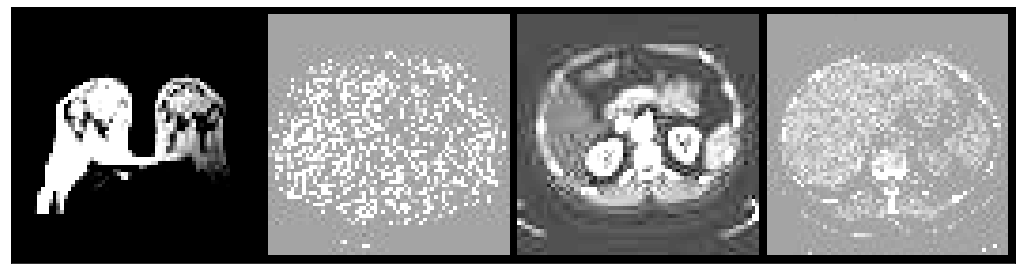

In [26]:
for images, labels in train_dataloader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [ ]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(400, 128)